In [1]:
import os
import time
import pandas as pd
import requests
from serpapi import GoogleSearch
from dotenv import load_dotenv
import re

# Load API Key from key.env file
load_dotenv("key.env")  # Ensure key.env is in the same directory
SERPAPI_KEY = os.getenv("SERPAPI_KEY")  # Retrieve API Key
if not SERPAPI_KEY:
    raise ValueError("SERPAPI_KEY is missing. Please set it in key.env file.")

# Updated regex to extract DOI
DOI_REGEX = re.compile(r'(10\.\d{4,9}/[-._;()/:A-Za-z0-9]+)')

def extract_doi(doi_string):
    """Extracts a valid DOI from a given string (URL or DOI) and removes trailing segments."""
    if pd.isna(doi_string) or doi_string == "N/A":
        return None
    match = DOI_REGEX.search(doi_string)
    if match:
        doi = match.group(0)
        # Remove any trailing segments if present (e.g., /full/html)
        if '/full' in doi:
            doi = doi.split('/full')[0]
        return doi
    return None

# Step 1: Collect Articles from Google Scholar
params = {
    "engine": "google_scholar",
    "q": "Marketing and Consumer Research",
    "api_key": SERPAPI_KEY,
    "num": 100
}

search = GoogleSearch(params)
results = search.get_dict().get("organic_results", [])

papers = []
for paper in results:
    publication_info = paper.get("publication_info", {})
    
    # Extract the publication year using several methods
    year = publication_info.get("year")
    if not year:
        year = publication_info.get("publication_year")
    if not year:
        summary = publication_info.get("summary", "")
        match = re.search(r'\b(19|20)\d{2}\b', summary)
        year = match.group(0) if match else "N/A"
    
    doi_link = paper.get("link", "N/A")  # May be a URL, not a true DOI
    doi = extract_doi(doi_link)  # Extract DOI if available

    papers.append({
        "Title": paper.get("title", "N/A"),
        "Authors": publication_info.get("authors", "N/A"),
        "Year": year,
        "Abstract": paper.get("snippet", "N/A"),
        "Citations": paper.get("inline_links", {}).get("cited_by", {}).get("total", 0),
        "DOI": doi if doi else "N/A",  # Use extracted DOI
        "References": ""  # Placeholder for references
    })

df = pd.DataFrame(papers)

# Step 2: Fetch References Using CrossRef API
def fetch_references(doi):
    """Fetch references from CrossRef API based on DOI."""
    if pd.isna(doi) or doi == "N/A":
        return "No DOI available"
    
    url = f"https://api.crossref.org/works/{doi}"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()  # Raise error for HTTP failures
        data = response.json()
        references = data.get('message', {}).get('reference', [])
        
        if not references:
            return "No references found"

        # Join the DOI or article title for each reference.
        return "; ".join([ref.get('DOI', ref.get('article-title', 'N/A')) for ref in references])
    
    except requests.exceptions.RequestException as e:
        print(f"Error fetching references for DOI {doi}: {e}")
        return "Error fetching references"

# Introduce a delay to avoid rate-limiting issues
for index, row in df.iterrows():
    if row['DOI'] != "N/A":
        df.at[index, 'References'] = fetch_references(row['DOI'])
        time.sleep(1)  # Prevent API rate limit issues

# Save the updated dataset
output_file = "google_scholar_marketing.csv"
df.to_csv(output_file, index=False)
print(f"Data collection completed with references. Saved as '{output_file}'.")


Error fetching references for DOI 10.4324/9780203402597/research-projects-marketing-management-consumer-research-chris-hackley: 404 Client Error: Not Found for url: https://api.crossref.org/works/10.4324/9780203402597/research-projects-marketing-management-consumer-research-chris-hackley
Error fetching references for DOI 10.4324/9781315829555-3/working-limits-method-possibilities-critical-reflexive-practice-marketing-consumer-research-shona-bettany-helen-woodruffe-burton: 404 Client Error: Not Found for url: https://api.crossref.org/works/10.4324/9781315829555-3/working-limits-method-possibilities-critical-reflexive-practice-marketing-consumer-research-shona-bettany-helen-woodruffe-burton
Error fetching references for DOI 10.1515/semi.2004.2004.152-1-4.1/html: 404 Client Error: Not Found for url: https://api.crossref.org/works/10.1515/semi.2004.2004.152-1-4.1/html
Error fetching references for DOI 10.4324/9781315873381-8/roots-marketing-consumer-research-university-chicago-1-sidney-lev

In [3]:
# 2. Data Cleaning & Filtering
# After extraction, we need to filter only peer-reviewed articles and remove duplicates.

import pandas as pd

# Load dataset
df = pd.read_csv("google_scholar_marketing.csv")

# Filter out records with missing years (often non-peer-reviewed)
df = df[df['Year'].notna()]

# Convert 'Year' to integer and remove old papers (e.g., before 2000)
df['Year'] = df['Year'].astype(int)
df = df[df['Year'] >= 2000]

# Remove duplicates
df.drop_duplicates(subset=['Title'], keep='first', inplace=True)

# Save cleaned dataset
df.to_csv("cleaned_marketing_articles.csv", index=False)
print(f"Cleaned dataset saved as 'cleaned_marketing_articles.csv' with {len(df)} articles.")


Cleaned dataset saved as 'cleaned_marketing_articles.csv' with 16 articles.


In [4]:
import pandas as pd

df = pd.read_csv("google_scholar_marketing.csv")

# Check the contents of the Year column
print(df["Year"].unique())


[1996 2015 2006 2003 2020 1999 2005 2008 2014 2001 2004 2024 2019 1995
 2012 1987]


In [5]:
# 3.1 Load Cleaned Data
import pandas as pd

# Load cleaned dataset
df = pd.read_csv("cleaned_marketing_articles.csv")

# Display first few rows
print(df.head())


                                               Title  \
0  Exploring the role of discourse in marketing a...   
1  Mapping consumer power: an integrative framewo...   
2  A critical review of construct indicators and ...   
3  Creating boundary-breaking, marketing-relevant...   
4  Doing research projects in marketing, manageme...   

                                             Authors  Year  \
0  [{'name': 'R Caruana', 'link': 'https://schola...  2015   
1  [{'name': 'J Denegri‐Knott', 'link': 'https://...  2006   
2  [{'name': 'CB Jarvis', 'link': 'https://schola...  2003   
3  [{'name': 'DJ MacInnis', 'link': 'https://scho...  2020   
4  [{'name': 'C Hackley', 'link': 'https://schola...  2003   

                                            Abstract  Citations  \
0  … analysis in marketing and consumer research ...         72   
1  … research program in marketing and consumer r...        507   
2  … a variety of different topic areas, includin...       8433   
3  … -breaking, market

In [6]:
# 3.2 Save in Different Formats
# CSV Format (Simple Export)
df.to_csv("marketing_graph_data.csv", index=False)
print("CSV file saved as 'marketing_graph_data.csv'.")

CSV file saved as 'marketing_graph_data.csv'.


In [7]:
# JSON Format
import json

df_json = df.to_dict(orient="records")
with open("marketing_graph_data.json", "w") as f:
    json.dump(df_json, f, indent=4)

print("JSON file saved as 'marketing_graph_data.json'.")

JSON file saved as 'marketing_graph_data.json'.


In [8]:
# GraphML Format (For Network Analysis)
#GraphML format is useful for network analysis using NetworkX.

import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes (publications)
for _, row in df.iterrows():
    G.add_node(row["Title"], year=row["Year"], authors=row["Authors"])

# Add citation edges (if references exist)
if "References" in df.columns:
    for _, row in df.iterrows():
        if pd.notna(row["References"]):
            references = row["References"].split(";")  # Assuming semicolon-separated references
            for ref in references:
                G.add_edge(ref.strip(), row["Title"])  # Edge from cited paper to citing paper

# Save GraphML
nx.write_graphml(G, "marketing_citation_network.graphml")
print("GraphML file saved as 'marketing_citation_network.graphml'.")


GraphML file saved as 'marketing_citation_network.graphml'.


In [9]:
# Step 4: Graph Processing & Visualization
# Now that the citation network is constructed, let's analyze and visualize it.

# 4.1 Basic Graph Statistics

print(f"Number of Nodes (Publications): {G.number_of_nodes()}")
print(f"Number of Edges (Citations): {G.number_of_edges()}")

# Compute Degree Distribution (Number of Citations per Paper)
degree_sequence = [G.degree(n) for n in G.nodes()]
print(f"Average Citations per Paper: {sum(degree_sequence)/len(degree_sequence):.2f}")

Number of Nodes (Publications): 471
Number of Edges (Citations): 479
Average Citations per Paper: 2.03


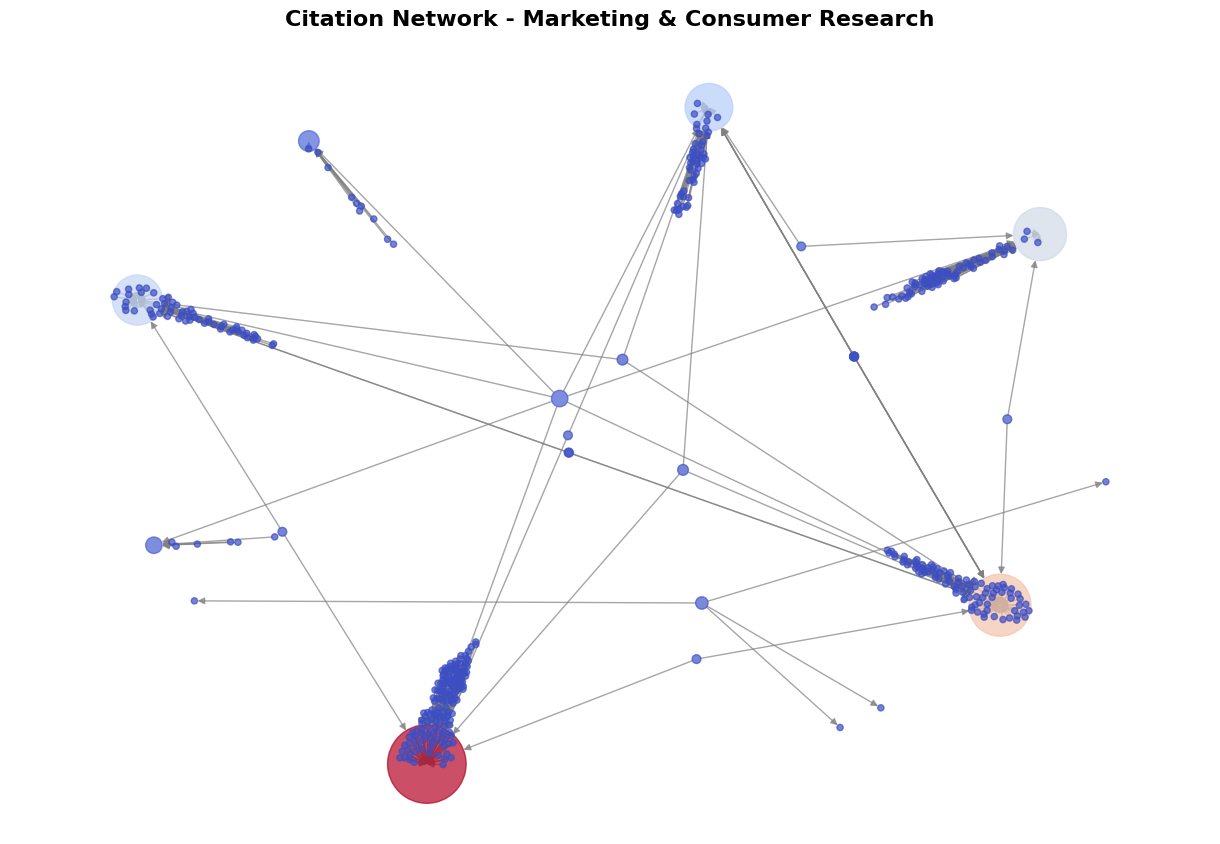

In [10]:
# 4.2 Visualizing the Citation Network
import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 7))
# nx.draw(G, with_labels=False, node_size=30, edge_color="gray")
# plt.title("Citation Network - Marketing & Consumer Research")
# plt.show()

plt.figure(figsize=(12, 8))
node_sizes = [G.degree(n) * 20 for n in G.nodes()]  # Scale node sizes by citation count
node_colors = [G.degree(n) for n in G.nodes()]  # Color nodes based on degree

nx.draw(
    G,
    with_labels=False,
    node_size=node_sizes,
    edge_color="gray",
    node_color=node_colors,
    cmap="coolwarm",
    alpha=0.7
)
plt.title("Citation Network - Marketing & Consumer Research", fontsize=16, fontweight="bold")
plt.show()



In [11]:
# 4.3 Identifying Most Cited Papers

# Sort by degree (most cited papers)
top_cited = sorted(G.degree, key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Most Cited Papers:")
for title, citations in top_cited:
    print(f"{title}: {citations} citations")

Top 10 Most Cited Papers:
Seeking sustainable futures in marketing and consumer research: 160 citations
Research contributions in interpretivist marketing and consumer research studies: a kaleidoscopic framework: 100 citations
Multicultural marketplaces: New territory for international marketing and consumer research: 73 citations
Exploring the role of discourse in marketing and consumer research: 65 citations
Creating boundary-breaking, marketing-relevant consumer research: 59 citations
Mapping consumer power: an integrative framework for marketing and consumer research: 11 citations
Videography in marketing and consumer research: 7 citations
N/A: 7 citations
Error fetching references: 4 citations
10.1086/426626: 3 citations


In [12]:
# Step 5: Graph Neural Network (GNN) Preparation (Optional)
# If you want to train a GNN for citation analysis, we need to convert our graph into PyG (PyTorch Geometric) format.

# 5.1 Convert NetworkX Graph to PyG Format

import torch
from torch_geometric.data import Data

# Convert nodes to integer indexes
node_mapping = {n: i for i, n in enumerate(G.nodes())}
edge_index = torch.tensor([[node_mapping[u], node_mapping[v]] for u, v in G.edges()], dtype=torch.long).t().contiguous()

# Create PyG Data Object
data = Data(edge_index=edge_index)
print(data)


Data(edge_index=[2, 479])


In [13]:
# 5.2.1 Install PyTorch Geometric
# pip install torch torchvision torchaudio
# pip install torch-geometric
# pip install torch-scatter torch-sparse torch-cluster torch-spline-conv


In [14]:
# 5.2.2 Load Graph Data into PyG Format
# Since we processed the citation network using NetworkX, we now convert it to PyG Data format:

import torch
from torch_geometric.data import Data
import networkx as nx

# Load GraphML citation network
G = nx.read_graphml("marketing_citation_network.graphml")

# Convert nodes to integer indices for PyG
node_mapping = {node: i for i, node in enumerate(G.nodes())}
edge_index = torch.tensor(
    [[node_mapping[src], node_mapping[dst]] for src, dst in G.edges()], dtype=torch.long
).t().contiguous()

# Assign random features (since we only have citation structure, not embeddings)
num_nodes = len(G.nodes())
node_features = torch.rand(num_nodes, 16)  # 16-dimensional random features
labels = torch.randint(0, 2, (num_nodes,))  # Binary label (e.g., High-cited = 1, Low-cited = 0)

# Create PyG Graph Data Object
data = Data(x=node_features, edge_index=edge_index, y=labels)
print("Graph Data:", data)


Graph Data: Data(x=[471, 16], edge_index=[2, 479], y=[471])


In [15]:
# 5.2.3 Define a Graph Convolutional Network (GCN)
# A Graph Convolutional Network (GCN) will process citation relationships to predict whether a paper is highly cited.

import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.nn as nn

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize model
model = GCN(input_dim=16, hidden_dim=32, output_dim=2)  # 2 output classes (Low-cited, High-cited)
print(model)


GCN(
  (conv1): GCNConv(16, 32)
  (conv2): GCNConv(32, 2)
)


In [16]:
# 5.2.4 Train the GCN Model
# Define Optimizer and Loss Function

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()

# Split dataset into train/test (80/20 split)
num_nodes = data.x.shape[0]
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[:int(0.8 * num_nodes)] = True
test_mask = ~train_mask


In [17]:
# Training Loop

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for 100 epochs
for epoch in range(200):
    loss = train()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.4f}")

print("Training complete!")


Epoch 0: Loss = 0.9736
Epoch 10: Loss = 0.7072
Epoch 20: Loss = 0.6921
Epoch 30: Loss = 0.6852
Epoch 40: Loss = 0.6792
Epoch 50: Loss = 0.6684
Epoch 60: Loss = 0.6553
Epoch 70: Loss = 0.6446
Epoch 80: Loss = 0.6333
Epoch 90: Loss = 0.6216
Epoch 100: Loss = 0.6080
Epoch 110: Loss = 0.5943
Epoch 120: Loss = 0.5804
Epoch 130: Loss = 0.5669
Epoch 140: Loss = 0.5531
Epoch 150: Loss = 0.5402
Epoch 160: Loss = 0.5281
Epoch 170: Loss = 0.5165
Epoch 180: Loss = 0.5050
Epoch 190: Loss = 0.4920
Training complete!


In [18]:
# 5.2.5 Evaluate Model on Test Data
def test():
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index)
        pred = logits.argmax(dim=1)  # Predicted classes
        correct = (pred[test_mask] == data.y[test_mask]).sum().item()
        accuracy = correct / test_mask.sum().item()
        print(f"Test Accuracy: {accuracy:.4f}")

test()


Test Accuracy: 0.5368


In [19]:
# Generate Node Embeddings
from node2vec import Node2Vec
import numpy as np

# Generate Node2Vec embeddings
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Save embeddings in a dictionary
embeddings = {node: model.wv[node] for node in G.nodes()}
print("Node embeddings generated.")


Computing transition probabilities:   0%|          | 0/471 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 88.24it/s] 


Node embeddings generated.


In [20]:
# Compute Influence Scores
# Influence can be measured using centrality metrics like PageRank or Degree Centrality.

# Compute influence scores using PageRank
pagerank_scores = nx.pagerank(G)

# Normalize scores to [0, 1]
max_score = max(pagerank_scores.values())
pagerank_scores = {k: v / max_score for k, v in pagerank_scores.items()}
print("PageRank scores computed and normalized.")


PageRank scores computed and normalized.


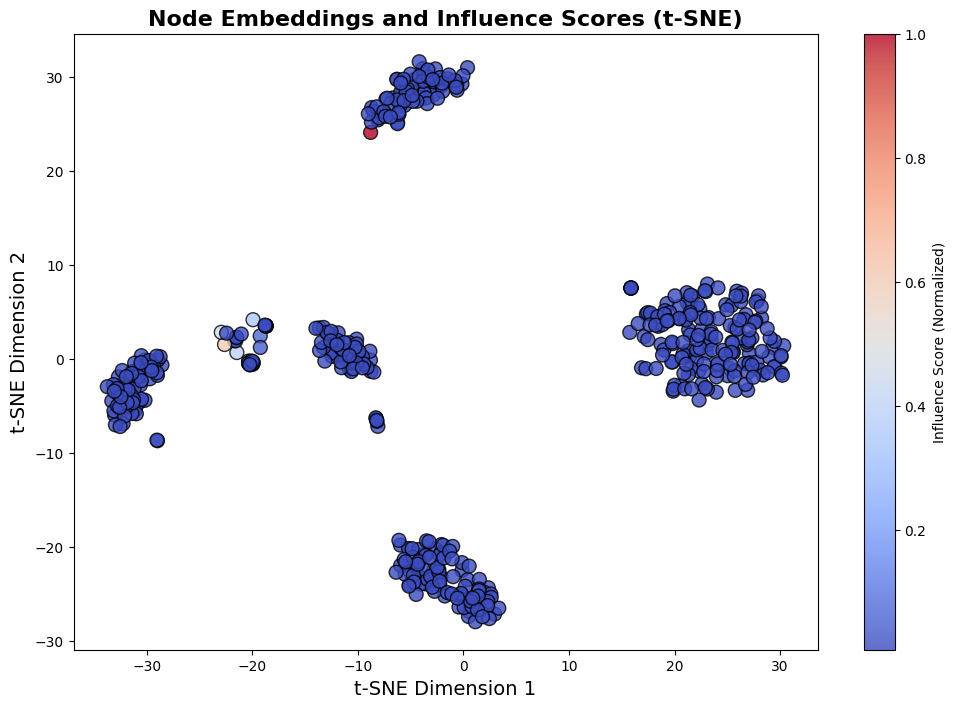

In [21]:
# Visualize Node Embeddings
# We'll use t-SNE to reduce the embedding dimensions (e.g., from 64 to 2) and matplotlib for visualization.

# Dimensionality Reduction with t-SNE

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Prepare embeddings and influence scores
node_embeddings = np.array(list(embeddings.values()))
node_labels = list(embeddings.keys())
influence = [pagerank_scores[node] for node in node_labels]

# Reduce dimensions to 2 using t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(node_embeddings)

# Plot the embeddings
plt.figure(figsize=(12, 8))
sc = plt.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    c=influence,
    cmap="coolwarm",
    s=100,  # Increase dot size
    edgecolor="black",
    alpha=0.8
)
plt.colorbar(sc, label="Influence Score (Normalized)")
plt.title("Node Embeddings and Influence Scores (t-SNE)", fontsize=16, fontweight="bold")
plt.xlabel("t-SNE Dimension 1", fontsize=14)
plt.ylabel("t-SNE Dimension 2", fontsize=14)

# Annotate key nodes
# for i, label in enumerate(node_labels[:5]):  # Annotate only top 5 nodes
#     plt.annotate(label, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=10)

plt.show()


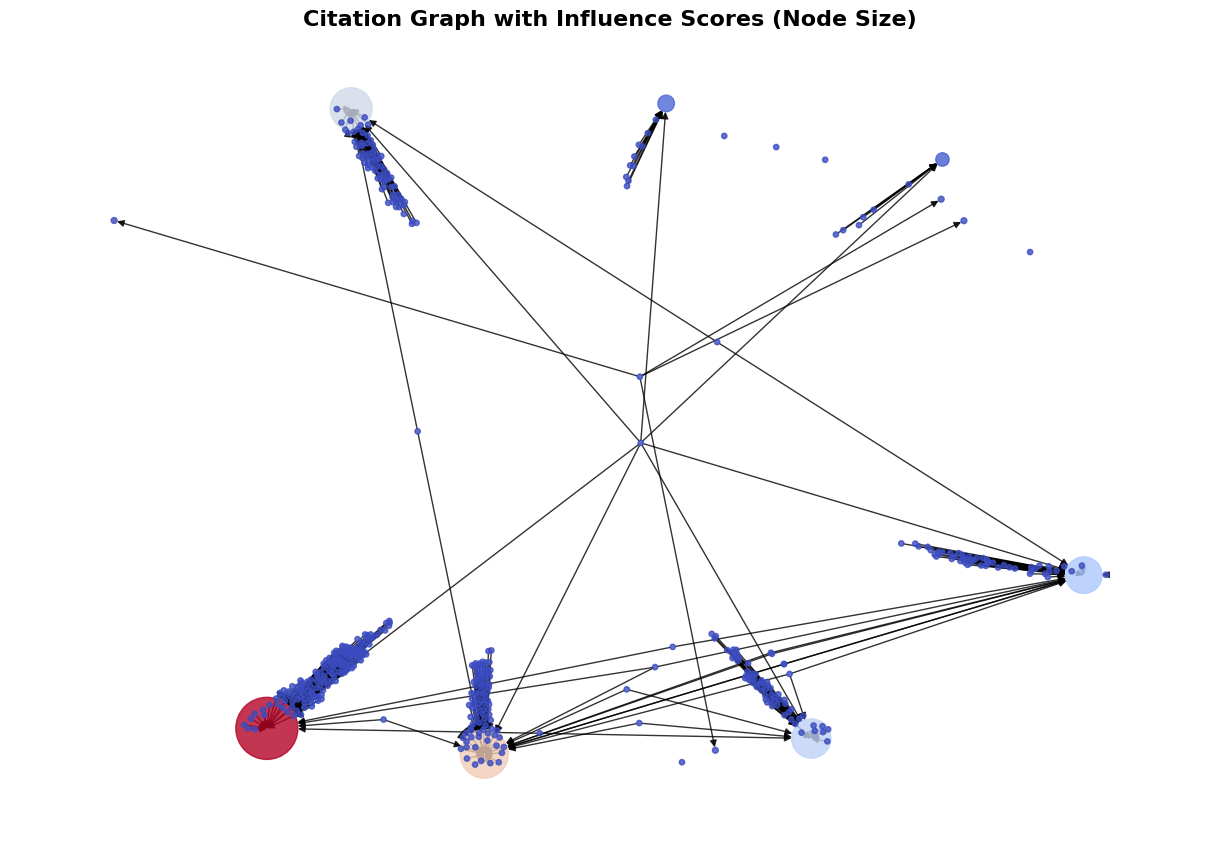

In [22]:
# Visualize Graph with Influence as Node Size
# You can also visualize the graph itself, with nodes sized by their influence scores.

plt.figure(figsize=(12, 8))
node_sizes = [pagerank_scores[node] * 2000 for node in G.nodes()]  # Scale sizes for better visualization
nx.draw(
    G,
    node_size=node_sizes,
    with_labels=False,
    node_color=list(pagerank_scores.values()),
    cmap="coolwarm",
    alpha=0.8
)
plt.title("Citation Graph with Influence Scores (Node Size)", fontsize=16, fontweight="bold")
plt.show()



In [23]:
# Apply K-Means Clustering
# We can use K-Means to cluster the node embeddings.

from sklearn.cluster import KMeans

# Number of clusters (choose based on domain knowledge or experimentation)
num_clusters = 5

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(node_embeddings)

# Assign clusters to nodes
node_clusters = {node: clusters[i] for i, node in enumerate(node_labels)}
print(f"Nodes grouped into {num_clusters} clusters.")


Nodes grouped into 5 clusters.


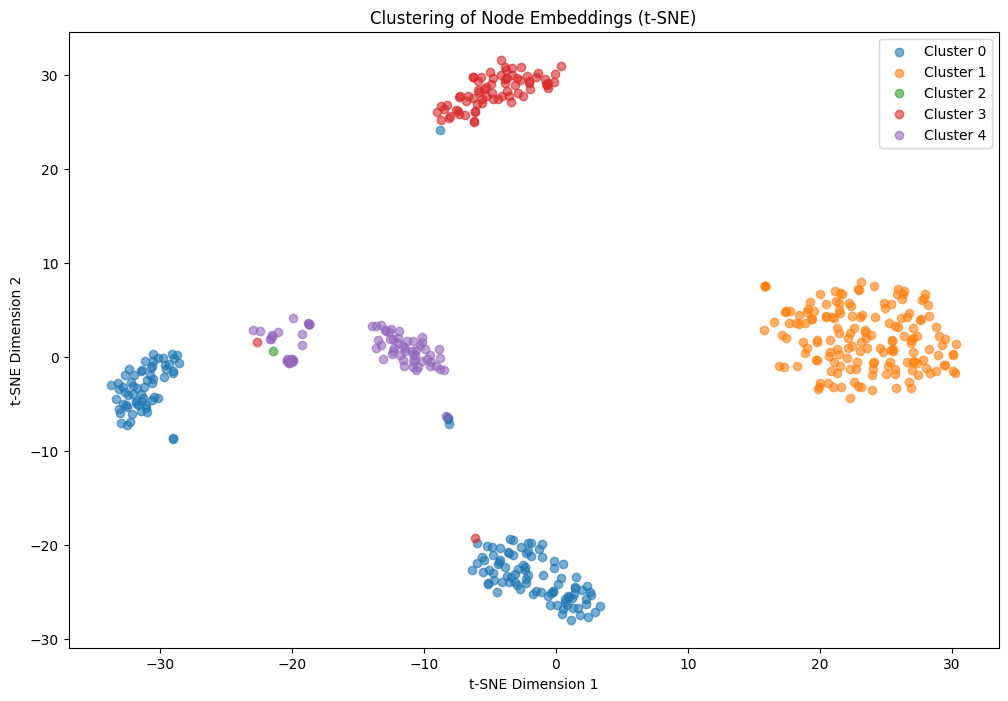

In [24]:
# Visualize Clusters with t-SNE

plt.figure(figsize=(12, 8))
for cluster in range(num_clusters):
    cluster_points = reduced_embeddings[clusters == cluster]
    plt.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        label=f"Cluster {cluster}",
        alpha=0.6,
    )

plt.title("Clustering of Node Embeddings (t-SNE)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()


In [25]:
# Semantic Analysis of Clusters
# Use clustering results to group papers into meaningful topics or areas of research.

# 2.1 Retrieve Papers in Each Cluster

for cluster in range(num_clusters):
    print(f"Cluster {cluster}:")
    cluster_nodes = [node for node, c in node_clusters.items() if c == cluster]
    print("\n".join(cluster_nodes[:5]))  # Display the first 5 papers in the cluster
    print("\n")


Cluster 0:
Seeking sustainable futures in marketing and consumer research
10.4337/9781784713959
10.1177/0018726700539002
10.1086/426626
10.1177/1470593111418796


Cluster 1:
A critical review of construct indicators and measurement model misspecification in marketing and consumer research
Statistics for marketing and consumer research
Consumer research for consumers
Towards (and beyond) LGBTQ+ studies in marketing and consumer research
Qualitative consumer and marketing research


Cluster 2:
Exploring the role of discourse in marketing and consumer research


Cluster 3:
Research contributions in interpretivist marketing and consumer research studies: a kaleidoscopic framework
10.1086/664037
10.1086/587629
10.1016/j.jbusres.2013.03.032
10.1509/jim.13.0032


Cluster 4:
Mapping consumer power: an integrative framework for marketing and consumer research
Creating boundary-breaking, marketing-relevant consumer research
Doing research projects in marketing, management and consumer research
V

In [26]:
# Analyze Common Features in Each Cluster
# You can analyze commonalities in metadata for each cluster (e.g., Year, Authors, Abstract).

# Create a DataFrame of clusters
df["Cluster"] = df["Title"].map(node_clusters)

# Analyze clusters
cluster_summary = df.groupby("Cluster").agg({
    "Year": "mean",
    "Citations": "mean",
    "Title": "count",
})
print(cluster_summary)


             Year  Citations  Title
Cluster                            
0        2020.000       83.0      1
1        2008.600     1988.2      5
2        2015.000       72.0      1
3        2024.000        9.0      1
4        2010.125      250.5      8


In [27]:
# Similarity Analysis
# Find similar papers based on their embeddings.

# 3.1 Compute Pairwise Cosine Similarities
# Cosine similarity is a common metric to measure similarity between embeddings.

from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(node_embeddings)

# Find top 5 similar papers for each node
top_similar = {}
for i, node in enumerate(node_labels):
    similar_indices = similarity_matrix[i].argsort()[-6:-1][::-1]  # Top 5 (excluding self)
    top_similar[node] = [(node_labels[j], similarity_matrix[i, j]) for j in similar_indices]

# Display top 5 similar papers for a sample paper
sample_paper = node_labels[0]
print(f"Top 5 papers similar to '{sample_paper}':")
for similar_paper, score in top_similar[sample_paper]:
    print(f"{similar_paper}: {score:.4f}")


Top 5 papers similar to 'Exploring the role of discourse in marketing and consumer research':
10.1080/10253866.2015.1067200: 0.4815
10.1086/209188: 0.4792
10.1108/JHRM-04-2014-0010: 0.4763
Pursuing the meaning of meaning in the commercial world: An international review of marketing and consumer research founded on semiotics: 0.4761
10.4135/9781446270035: 0.4746


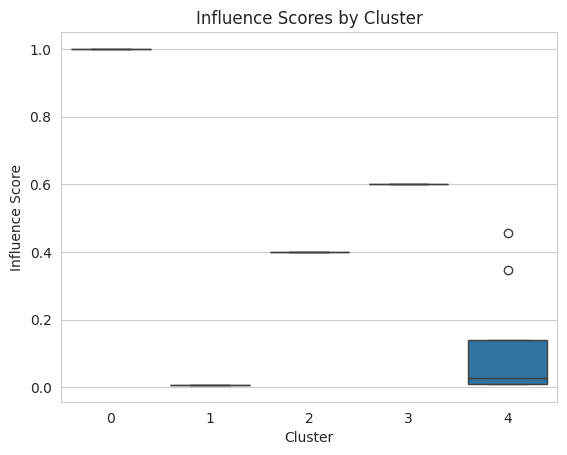

In [29]:
# Influence vs. Clusters
# Analyze the distribution of influence scores within clusters.

import seaborn as sns

# Add influence scores to DataFrame
df["Influence"] = df["Title"].map(pagerank_scores)

# Plot influence scores by cluster
sns.boxplot(x="Cluster", y="Influence", data=df)
plt.title("Influence Scores by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Influence Score")
plt.show()



In [30]:
# Embedding Distance Analysis
# Measure the spread or cohesiveness of embeddings in the graph.

# 5.1 Compute Average Distance to Centroid

# Compute centroid of embeddings
centroid = node_embeddings.mean(axis=0)

# Compute distances of each node to the centroid
distances = np.linalg.norm(node_embeddings - centroid, axis=1)

# Analyze distances
print(f"Mean distance to centroid: {np.mean(distances):.4f}")
print(f"Standard deviation: {np.std(distances):.4f}")


Mean distance to centroid: 1.0169
Standard deviation: 0.6990


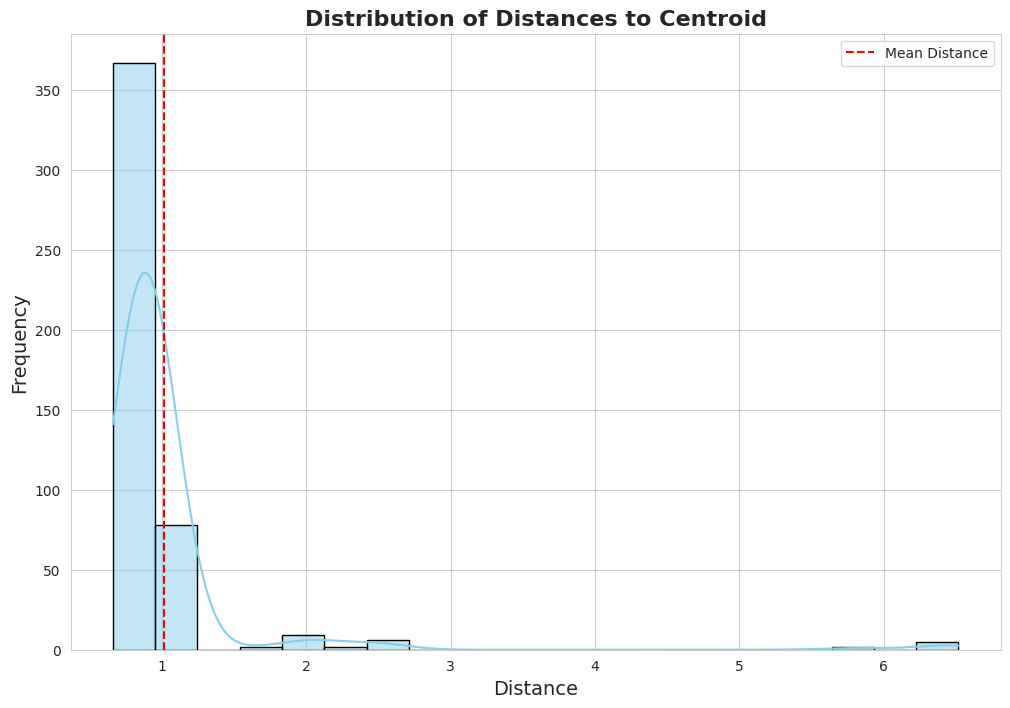

In [31]:
# Visualize Distance Distribution

# plt.hist(distances, bins=20, color="skyblue", edgecolor="black")
# plt.title("Distribution of Distances to Centroid")
# plt.xlabel("Distance")
# plt.ylabel("Frequency")
# plt.show()

plt.figure(figsize=(12, 8))
sns.histplot(distances, bins=20, color="skyblue", edgecolor="black", kde=True)
plt.axvline(np.mean(distances), color="red", linestyle="--", label="Mean Distance")

plt.title("Distribution of Distances to Centroid", fontsize=16, fontweight="bold")
plt.xlabel("Distance", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.show()



In [ ]:
# Graph Modularity: Community Detection
# We’ll use the Louvain algorithm to detect communities in the graph. Louvain is efficient for large graphs and works well with weighted networks.

# import community as community_louvain
# import networkx as nx
# import matplotlib.pyplot as plt

# Detect communities using the Louvain algorithm
# partition = community_louvain.best_partition(G, weight='weight')  # Weighted graph
# print(f"Number of communities detected: {len(set(partition.values()))}")

# Add communities to the graph
# nx.set_node_attributes(G, partition, "community")

# Visualize the graph with communities
# plt.figure(figsize=(12, 8))
# pos = nx.spring_layout(G, seed=42)  # Position nodes using a spring layout
# communities = list(partition.values())
# nx.draw(
#     G, pos, node_color=communities, cmap=plt.cm.tab20, node_size=50, with_labels=False
# )
# plt.title("Graph Communities (Louvain Algorithm)")
# plt.show()

Number of communities detected: 12


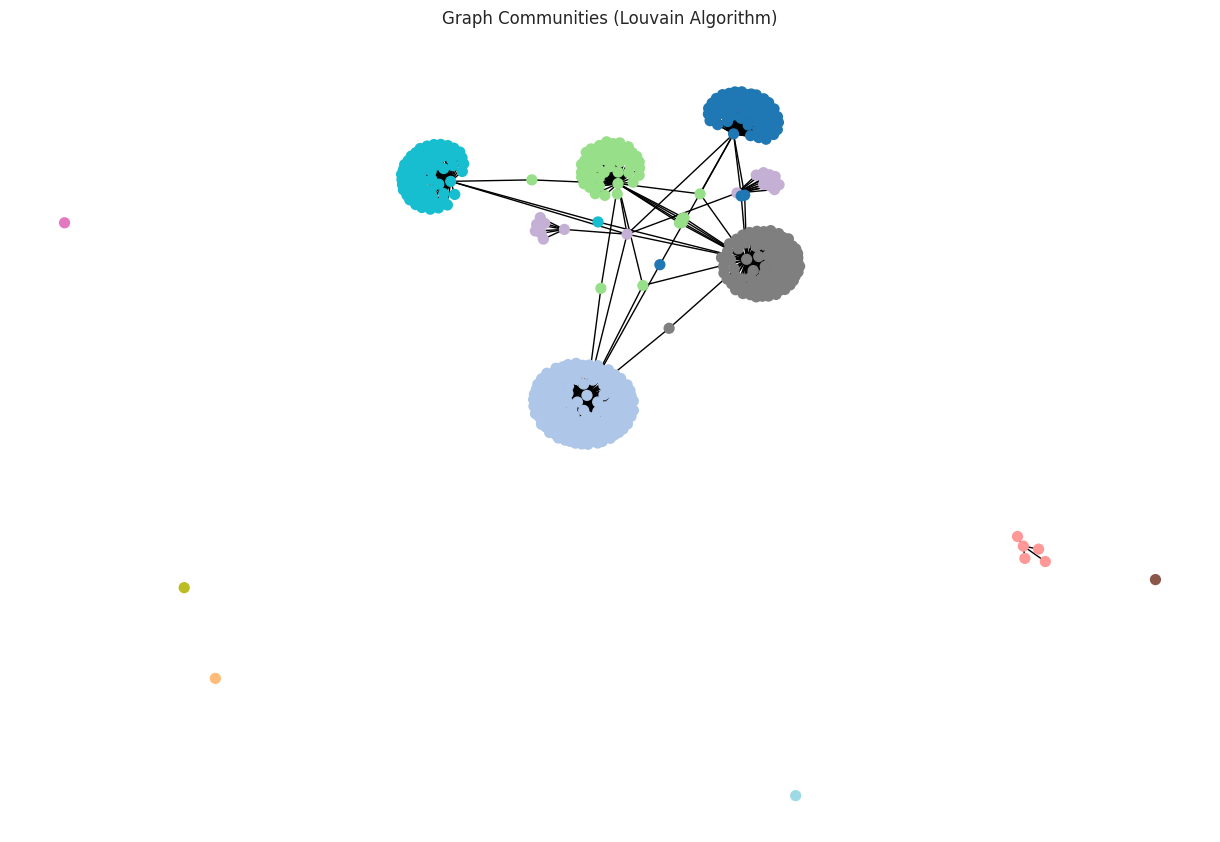

In [32]:
# Convert directed graph to undirected graph

import community as community_louvain
import networkx as nx
import matplotlib.pyplot as plt

G_undirected = G.to_undirected()

# Run the Louvain algorithm on the undirected graph
partition = community_louvain.best_partition(G_undirected, weight='weight')
print(f"Number of communities detected: {len(set(partition.values()))}")

# Add communities as attributes to the graph
nx.set_node_attributes(G_undirected, partition, "community")

# Visualize the graph with communities
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_undirected, seed=42)  # Position nodes using a spring layout
communities = list(partition.values())
nx.draw(
    G_undirected, pos, node_color=communities, cmap=plt.cm.tab20, node_size=50, with_labels=False
)
plt.title("Graph Communities (Louvain Algorithm)")
plt.show()


In [33]:
# Edge Prediction with Node Embeddings
# Edge prediction involves training a machine learning model to predict missing edges based on the similarity of node embeddings.

# 2.1 Generate Positive and Negative Edge Samples
# We need both positive (existing edges) and negative (non-existing edges) samples to train the model.

# Generate Positive Edges

import random

# Get existing edges
edges = list(G.edges())

# Generate positive samples
positive_samples = [(u, v, 1) for u, v in edges]


In [34]:
# Generate Negative Edges


# Generate negative edges (non-existing edges)
nodes = list(G.nodes())
negative_samples = []

while len(negative_samples) < len(edges):  # Balance positive and negative samples
    u, v = random.sample(nodes, 2)  # Random pair of nodes
    if not G.has_edge(u, v):  # Ensure it's a non-existing edge
        negative_samples.append((u, v, 0))



In [35]:
# Prepare Features and Labels
# For each edge (u, v), compute the feature vector as the concatenation of node embeddings.

import numpy as np

# Combine positive and negative samples
all_samples = positive_samples + negative_samples
random.shuffle(all_samples)

# Create features (concatenation of embeddings) and labels
X = np.array(
    [
        np.concatenate((embeddings[u], embeddings[v]))
        for u, v, label in all_samples
    ]
)
y = np.array([label for _, _, label in all_samples])


In [36]:
# Train a Machine Learning Model
# Use a simple classifier (e.g., Logistic Regression) to predict edges.

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

print(f"Edge Prediction Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")


Edge Prediction Accuracy: 0.9948
ROC-AUC Score: 1.0000


In [37]:
# Predict New Edges
# Use the trained model to predict edges that are most likely missing from the graph.

# Generate all possible non-existing edges
non_existing_edges = [
    (u, v)
    for u in nodes
    for v in nodes
    if u != v and not G.has_edge(u, v)
]

# Prepare features for non-existing edges
X_new = np.array(
    [
        np.concatenate((embeddings[u], embeddings[v]))
        for u, v in non_existing_edges
    ]
)

# Predict probabilities of edges
probs = clf.predict_proba(X_new)[:, 1]

# Get top predicted edges
top_edges = sorted(
    zip(non_existing_edges, probs), key=lambda x: x[1], reverse=True
)[:10]

print("Top 10 Predicted Edges:")
for edge, prob in top_edges:
    print(f"Edge {edge} with probability {prob:.4f}")


Top 10 Predicted Edges:
Edge ('Error fetching references', 'Seeking sustainable futures in marketing and consumer research') with probability 1.0000
Edge ('Mapping consumer power: an integrative framework for marketing and consumer research', 'Seeking sustainable futures in marketing and consumer research') with probability 1.0000
Edge ('Videography in marketing and consumer research', 'Seeking sustainable futures in marketing and consumer research') with probability 1.0000
Edge ('Error fetching references', 'Creating boundary-breaking, marketing-relevant consumer research') with probability 0.9999
Edge ('Multicultural marketplaces: New territory for international marketing and consumer research', 'Seeking sustainable futures in marketing and consumer research') with probability 0.9999
Edge ('Mapping consumer power: an integrative framework for marketing and consumer research', 'Creating boundary-breaking, marketing-relevant consumer research') with probability 0.9999
Edge ('Videograph

In [ ]:
# Sankey Diagram for Communities
# This visualization represents the distribution of different communities.

import plotly.graph_objects as go
from collections import Counter
import random

# Count the size of each community (i.e., number of nodes in each community)
community_counts = Counter(partition.values())
community_ids = list(community_counts.keys())
community_sizes = list(community_counts.values())

# Prepare data for the Sankey diagram
source = []
target = []
value = []

# Generate meaningful interaction values (instead of zeros)
for i, comm in enumerate(community_ids):
    for j, comm2 in enumerate(community_ids):
        if i != j:
            # Randomly assign a value based on community size (or use domain knowledge)
            flow_value = random.randint(1, 10)  # Example: Replace with actual relationship values if available
            source.append(i)
            target.append(j)
            value.append(flow_value)  

# Ensure we have meaningful values
if not any(value):
    print("Warning: No meaningful connections found between communities. The Sankey diagram may not be informative.")

# Create Sankey Diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=[f"Community {i} ({community_counts[i]})" for i in community_ids],  # Include size info
        color="blue"
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color="rgba(100, 149, 237, 0.4)"  # Light blue with transparency
    )
)])

fig.update_layout(
    title_text="Community Distribution in the Graph",
    font_size=12,
    height=600,
    width=900
)
fig.show()


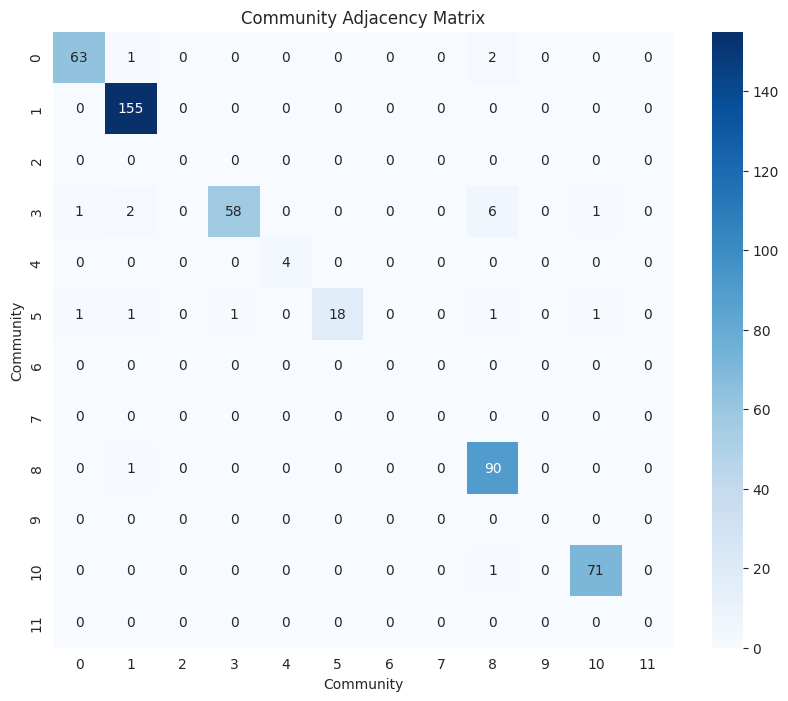

In [38]:
# Heatmap of Community Adjacencies
# Show how nodes from different communities are connected.

import numpy as np
import seaborn as sns

# Adjacency matrix with communities
num_communities = len(set(partition.values()))
adj_matrix = np.zeros((num_communities, num_communities))

# Populate the adjacency matrix
for u, v in G.edges():
    comm_u = partition[u]
    comm_v = partition[v]
    adj_matrix[comm_u, comm_v] += 1

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(adj_matrix, annot=True, cmap="Blues", fmt=".0f")
plt.title("Community Adjacency Matrix")
plt.xlabel("Community")
plt.ylabel("Community")
plt.show()


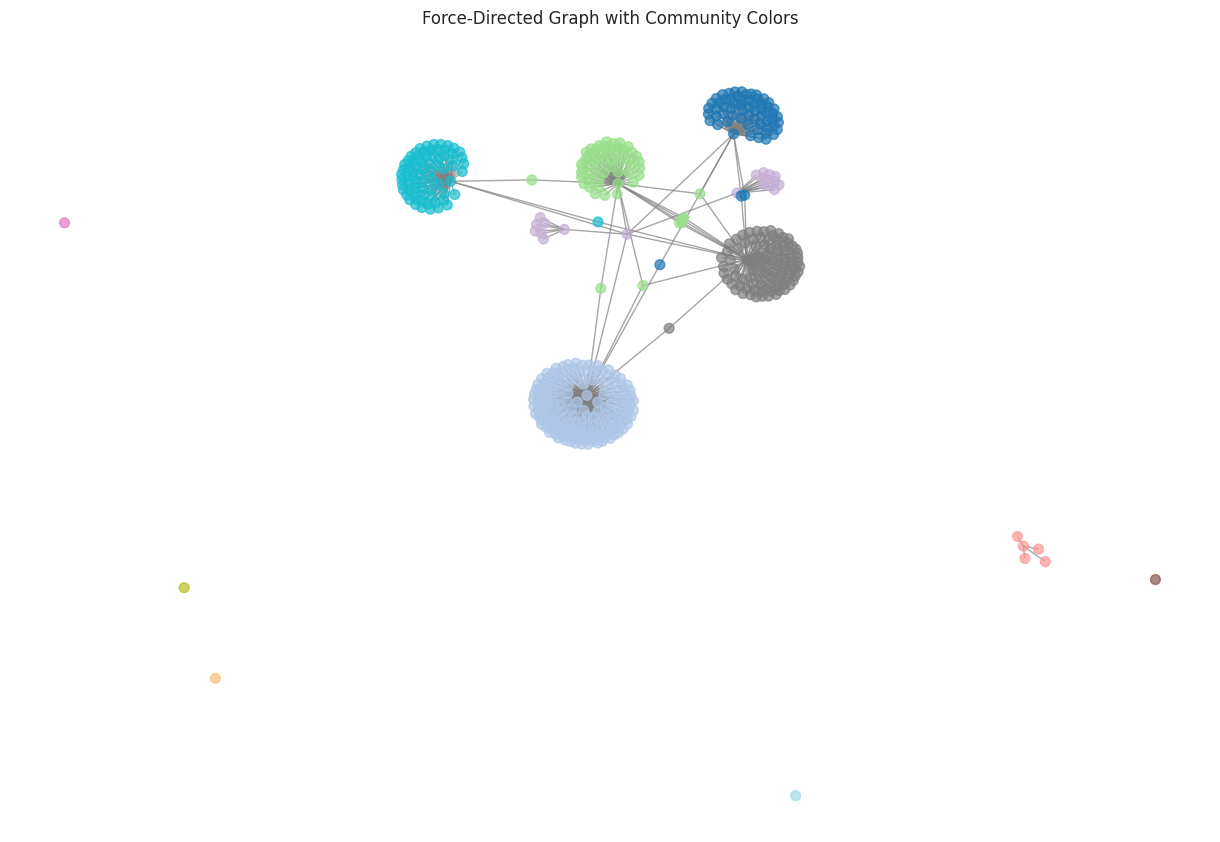

In [39]:
# Force-Directed Graph with Community Colors
# Use NetworkX with a force-directed layout, coloring nodes by their community membership.

plt.figure(figsize=(12, 8))

# Draw the graph with nodes colored by their community
pos = nx.spring_layout(G_undirected, seed=42)  # Force-directed layout
nx.draw(
    G_undirected,
    pos,
    node_color=list(partition.values()),
    cmap=plt.cm.tab20,
    node_size=50,
    with_labels=False,
    edge_color="gray",
    alpha=0.7,
)
plt.title("Force-Directed Graph with Community Colors")
plt.show()


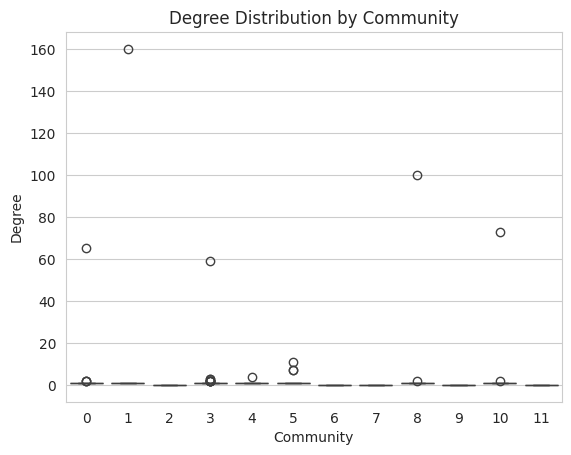

In [40]:
# Degree Distribution by Community
# Visualize the degree distribution for nodes within each community.

import pandas as pd

# Compute degree for each node
degree_dict = dict(G.degree())
df_community = pd.DataFrame({
    "Node": list(G.nodes()),
    "Community": [partition[node] for node in G.nodes()],
    "Degree": [degree_dict[node] for node in G.nodes()],
})

# Plot degree distribution for each community
sns.boxplot(x="Community", y="Degree", data=df_community)
plt.title("Degree Distribution by Community")
plt.xlabel("Community")
plt.ylabel("Degree")
plt.show()


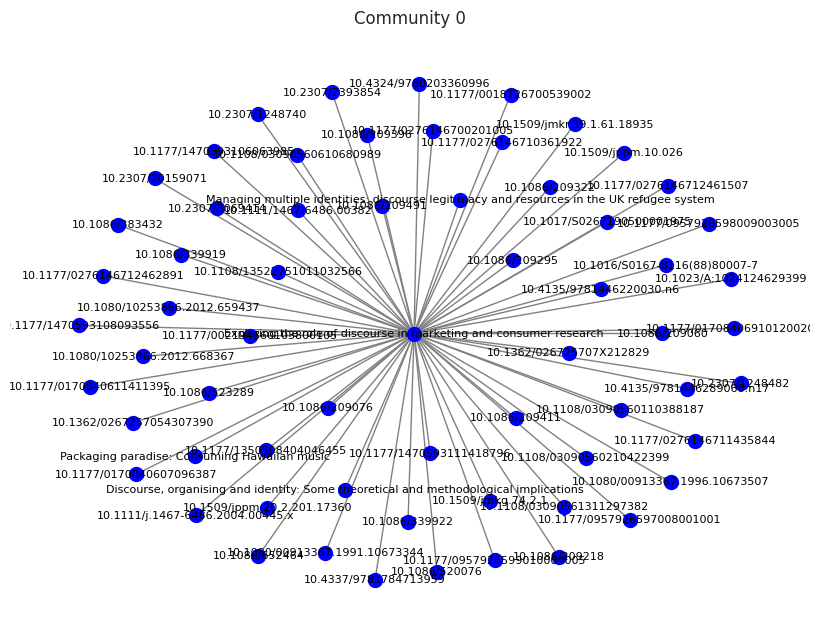

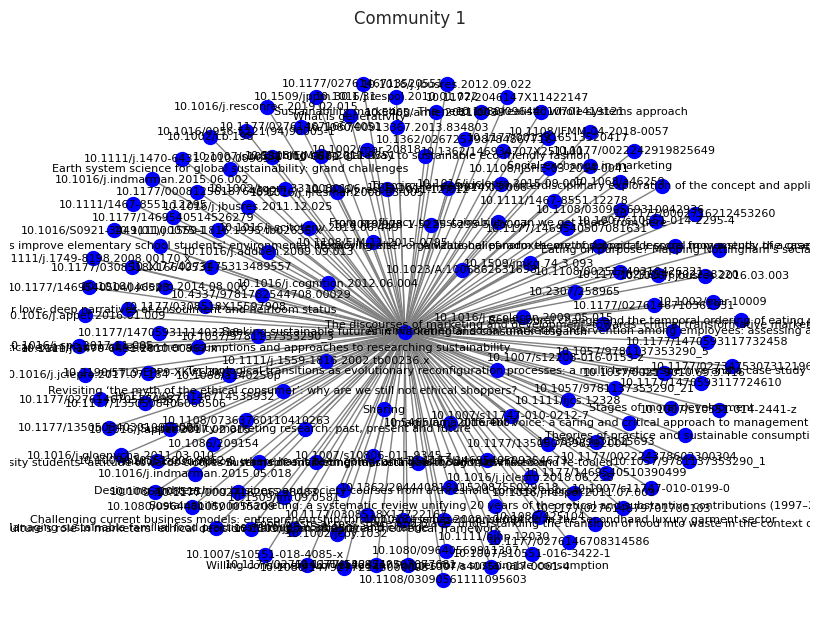

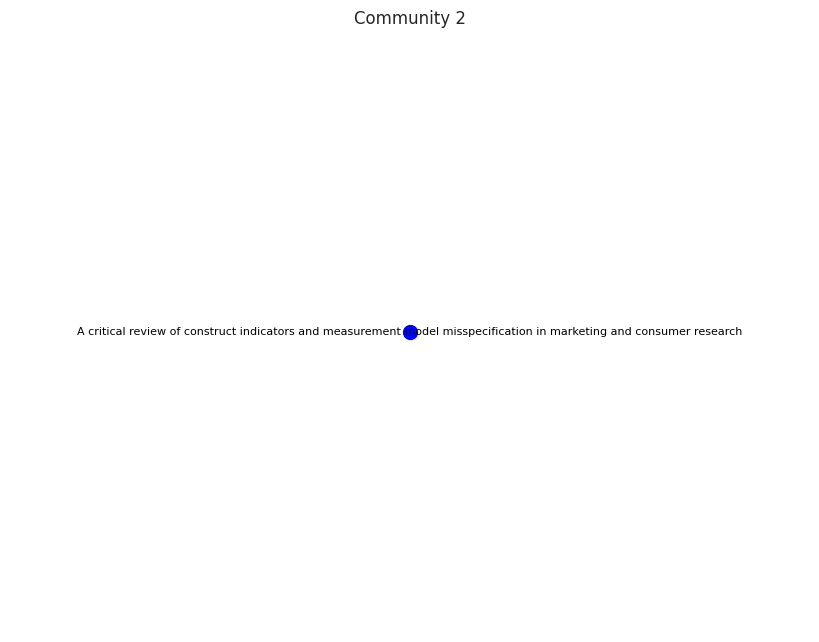

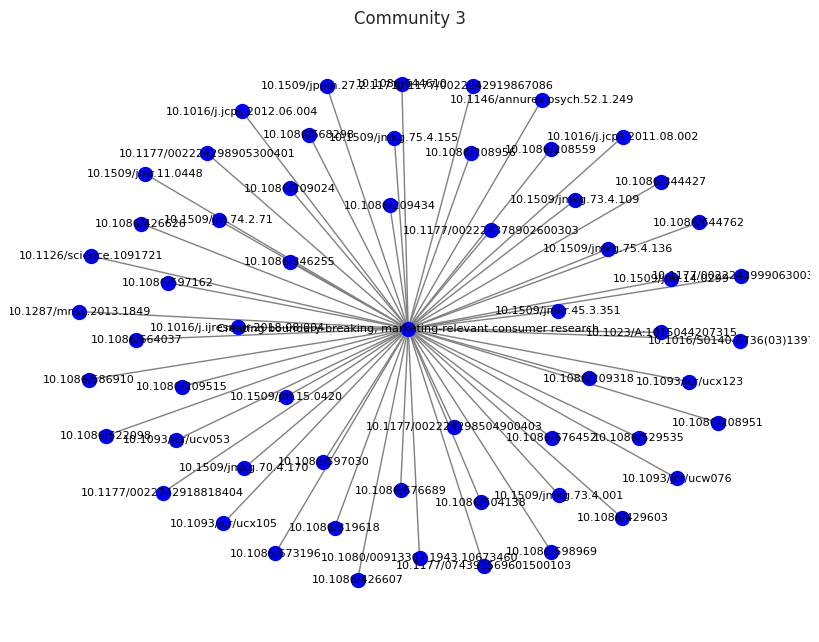

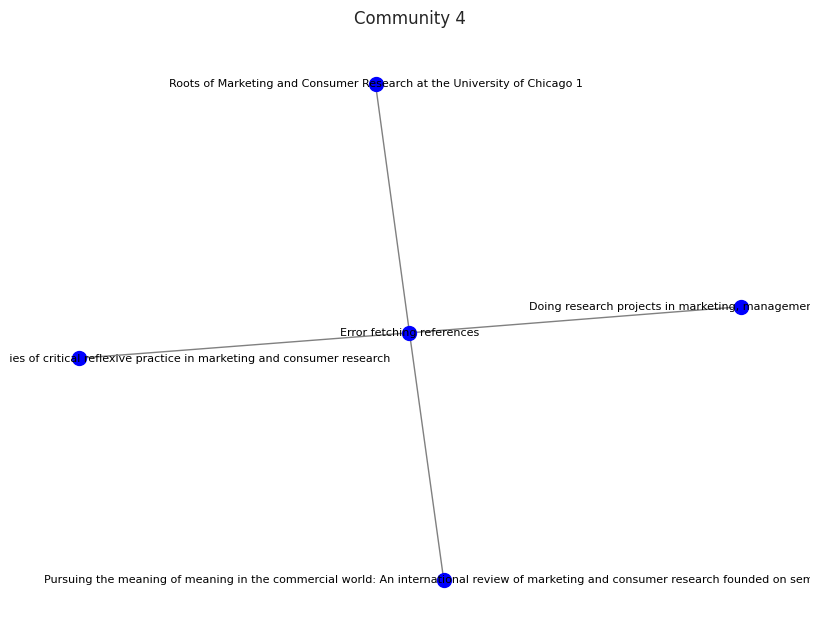

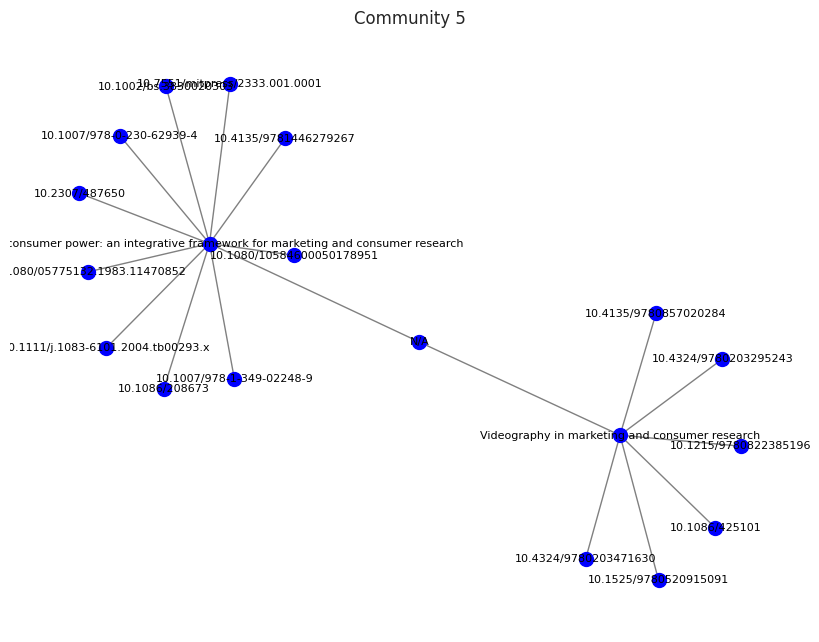

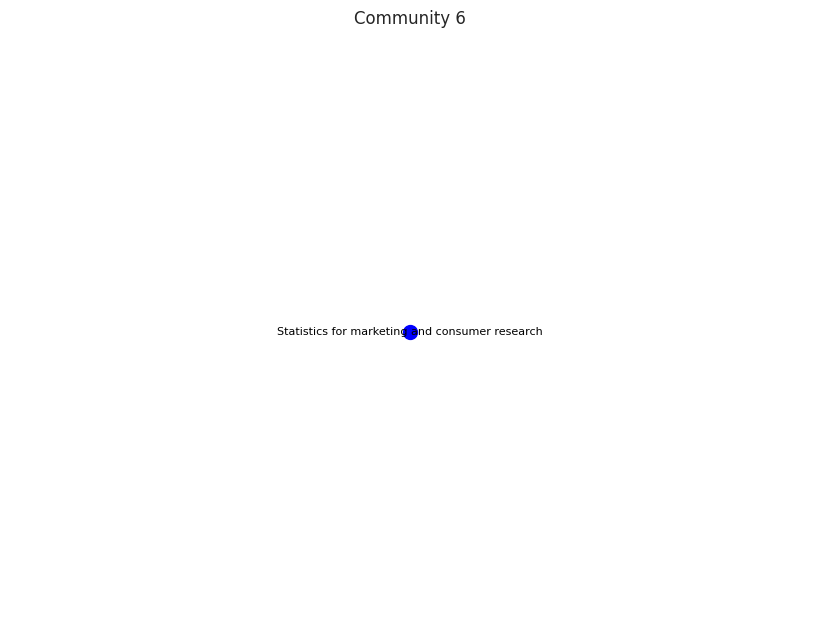

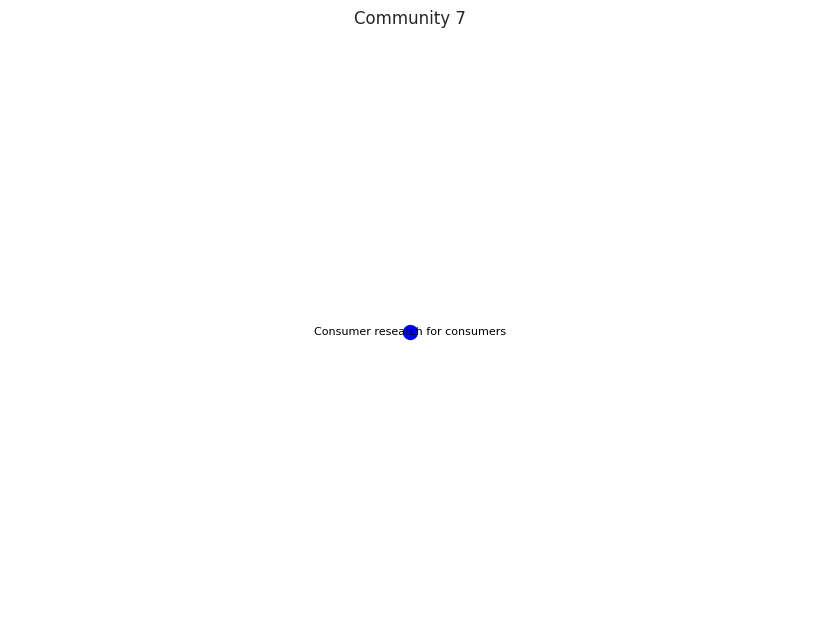

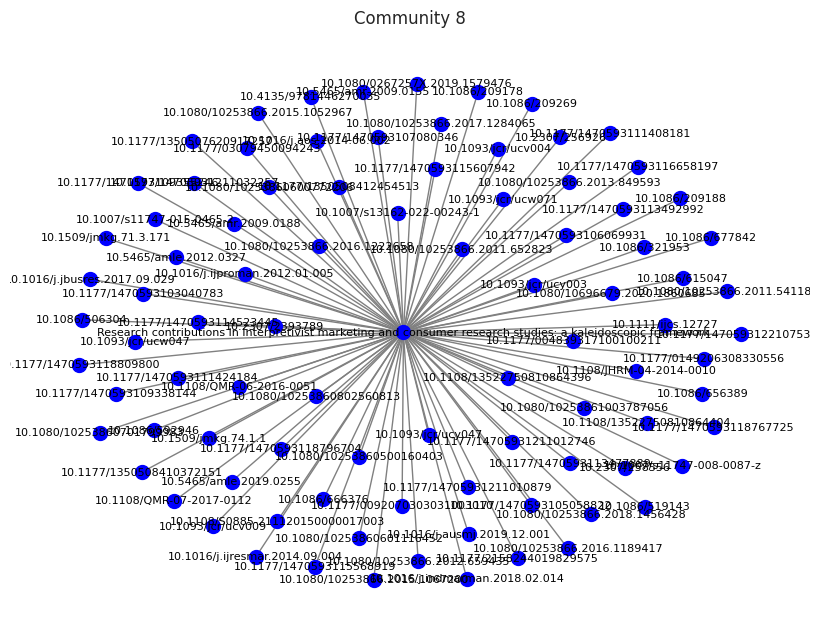

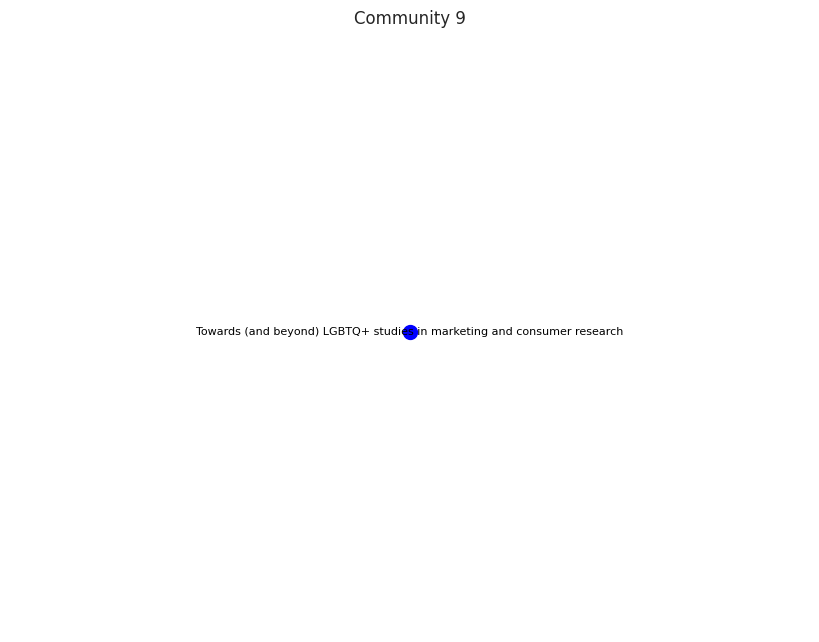

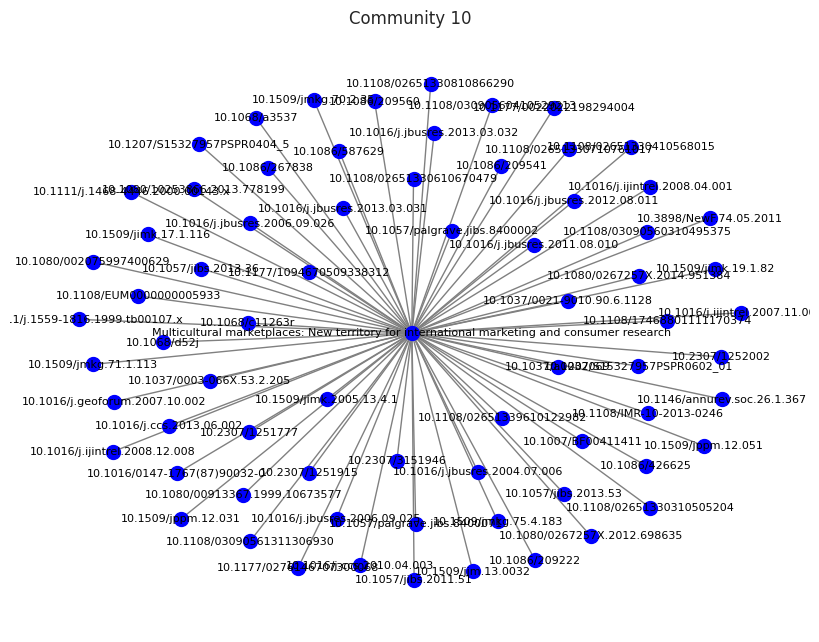

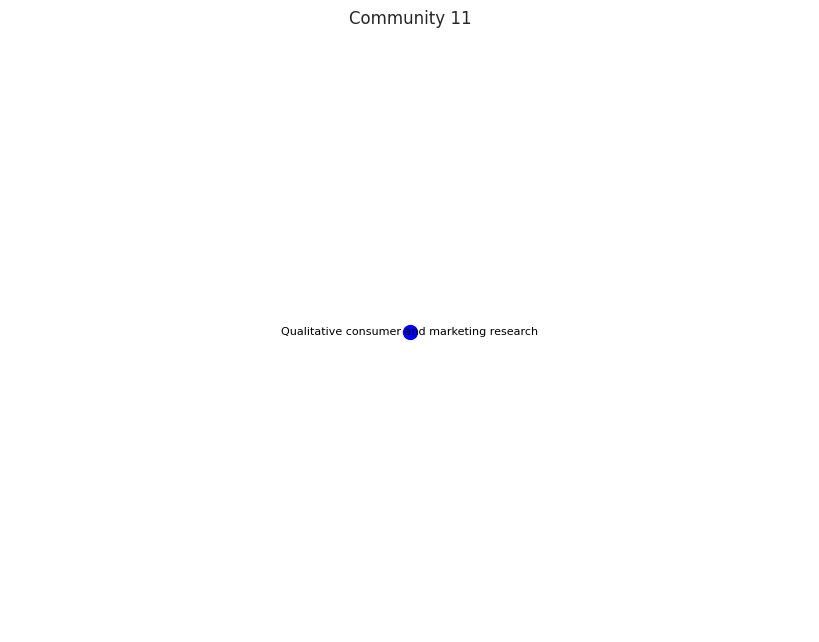

In [42]:
# Community Subgraph Visualization
# Visualize individual communities as subgraphs.

for comm_id in set(partition.values()):
    subgraph_nodes = [node for node, comm in partition.items() if comm == comm_id]
    subgraph = G_undirected.subgraph(subgraph_nodes)

    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(subgraph, seed=42)
    nx.draw(
        subgraph,
        pos,
        node_size=100,
        node_color="blue",
        with_labels=True,
        font_size=8,
        edge_color="gray",
    )
    plt.title(f"Community {comm_id}")
    plt.show()


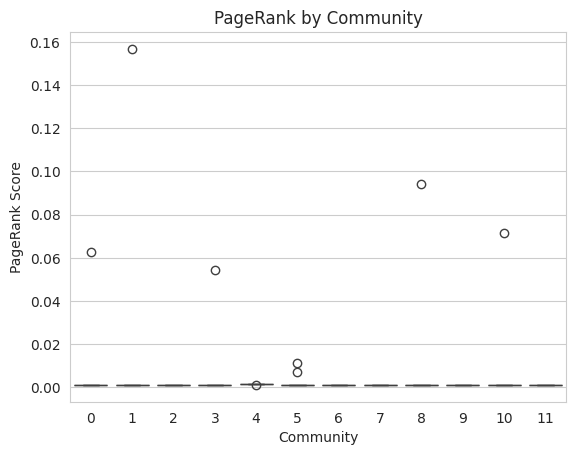

In [41]:
# Node Centrality vs. Communities
# # Visualize centrality (e.g., degree or PageRank) scores grouped by communities.

# Compute centrality (PageRank)
pagerank = nx.pagerank(G)
df_centrality = pd.DataFrame({
    "Node": list(G.nodes()),
    "Community": [partition[node] for node in G.nodes()],
    "PageRank": [pagerank[node] for node in G.nodes()],
})

# Boxplot of PageRank by community
sns.boxplot(x="Community", y="PageRank", data=df_centrality)
plt.title("PageRank by Community")
plt.xlabel("Community")
plt.ylabel("PageRank Score")
plt.show()


In [43]:
# Interactive Visualization with Pyvis
# Create an interactive, zoomable graph visualization.

from pyvis.network import Network

# Create a Pyvis network
net = Network(notebook=True, height="750px", width="100%", bgcolor="#222222", font_color="white")
net.from_nx(G_undirected)

# Assign node colors based on community
for node in G_undirected.nodes():
    net.get_node(node)["color"] = plt.cm.tab20(partition[node])

# Show the network
net.show("graph.html")


graph.html
